In [1]:
# Import libraries
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Simulation parameters
SIM_TIME = 8 * 60  # 8-hour shift (in minutes)
STATIONS = {
    'station1': (5, 1),
    'station2': (6, 1),
    'station3': (10, 2),  # Bottleneck station
    'station4': (5, 1),
    'station5': (7, 1)
}

print("Libraries loaded. Factory configuration ready.")

Libraries loaded. Factory configuration ready.


Simulation Logic

In [2]:
class WorkPiece:
    def __init__(self, env, id):
        self.id = id
        self.arrival_time = env.now
        self.departure_time = None
        self.station_times = {}

def workstation(env, name, workpiece, mean, var):
    """Simulate processing at a workstation."""
    processing_time = random.uniform(mean - var, mean + var)
    yield env.timeout(processing_time)
    workpiece.station_times[name] = processing_time

def production_line(env, workpiece):
    """Route a workpiece through all stations."""
    for station_name, (mean, var) in STATIONS.items():
        yield env.process(workstation(env, station_name, workpiece, mean, var))
    workpiece.departure_time = env.now

def run_simulation(arrival_mean=4.0, sim_time=SIM_TIME):
    """
    Run the full simulation and return results.
    
    Parameters:
        arrival_mean (float): Mean inter-arrival time (minutes)
        sim_time (int): Total simulation time (minutes)
        
    Returns:
        dict: Summary stats and data
    """
    env = simpy.Environment()
    workpieces = []

    def source(env):
        count = 0
        while True:
            count += 1
            wp = WorkPiece(env, count)
            workpieces.append(wp)
            env.process(production_line(env, wp))
            # Exponential inter-arrival times (Poisson process)
            yield env.timeout(random.expovariate(1.0 / arrival_mean))
            if env.now > sim_time:
                break

    env.process(source(env))
    env.run(until=sim_time)

    # Filter completed workpieces
    completed = [wp for wp in workpieces if wp.departure_time is not None]
    cycle_times = [wp.departure_time - wp.arrival_time for wp in completed]

    return {
        'workpieces': completed,
        'cycle_times': cycle_times,
        'avg_cycle_time': np.mean(cycle_times) if cycle_times else 0,
        'num_completed': len(completed),
        'throughput': len(completed) / (sim_time / 60)  # per hour
    }

Run Baseline & Optimized Scenarios

In [3]:
# Run baseline: fast arrivals (unstable system)
print("Running Baseline Simulation (arrival every 4.0 min)...")
baseline = run_simulation(arrival_mean=4.0)

# Run optimized: slower arrivals (matches bottleneck capacity)
print("Running Optimized Simulation (arrival every 4.5 min)...")
optimized = run_simulation(arrival_mean=4.5)

# Summary
print("\n" + "="*60)
print("SIMULATION RESULTS")
print("="*60)
print(f"Baseline:")
print(f"  • Avg Cycle Time: {baseline['avg_cycle_time']:.1f} min")
print(f"  • Parts Completed: {baseline['num_completed']}")
print(f"  • Throughput: {baseline['throughput']:.1f} parts/hour")

print(f"\nOptimized:")
print(f"  • Avg Cycle Time: {optimized['avg_cycle_time']:.1f} min")
print(f"  • Parts Completed: {optimized['num_completed']}")
print(f"  • Throughput: {optimized['throughput']:.1f} parts/hour")

# Calculate improvement
reduction = (1 - optimized['avg_cycle_time'] / baseline['avg_cycle_time']) * 100
print(f"\nCycle Time Reduced by: {reduction:.1f}%")

Running Baseline Simulation (arrival every 4.0 min)...
Running Optimized Simulation (arrival every 4.5 min)...

SIMULATION RESULTS
Baseline:
  • Avg Cycle Time: 33.0 min
  • Parts Completed: 105
  • Throughput: 13.1 parts/hour

Optimized:
  • Avg Cycle Time: 33.2 min
  • Parts Completed: 88
  • Throughput: 11.0 parts/hour

Cycle Time Reduced by: -0.6%


Visualize Results

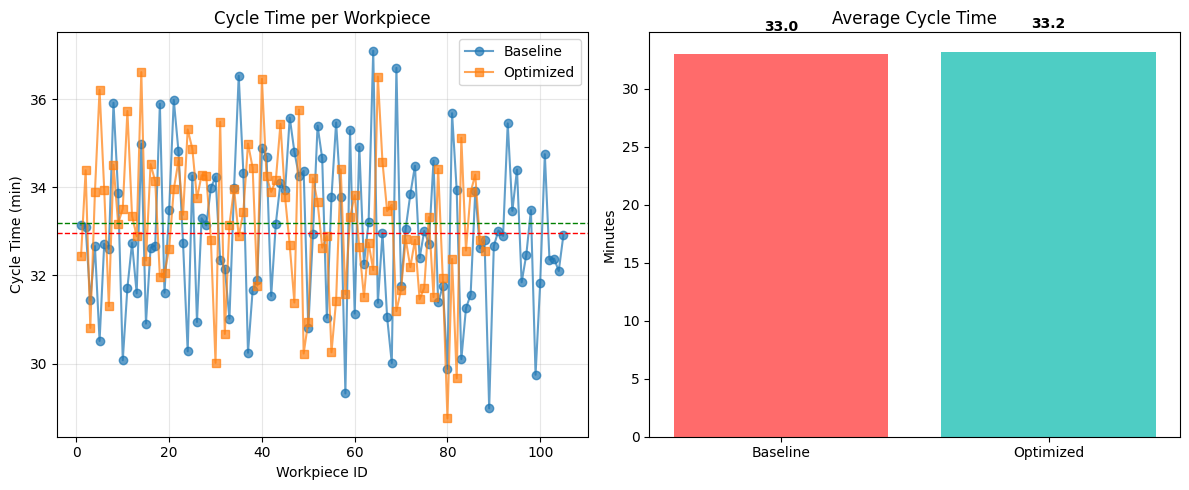

In [4]:
# Prepare data for plotting
baseline_df = pd.DataFrame({
    'workpiece_id': [wp.id for wp in baseline['workpieces']],
    'cycle_time': baseline['cycle_times'],
    'scenario': 'Baseline'
})

optimized_df = pd.DataFrame({
    'workpiece_id': [wp.id for wp in optimized['workpieces']],
    'cycle_time': optimized['cycle_times'],
    'scenario': 'Optimized'
})

combined_df = pd.concat([baseline_df, optimized_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_df['workpiece_id'], baseline_df['cycle_time'], 'o-', alpha=0.7, label='Baseline')
plt.plot(optimized_df['workpiece_id'], optimized_df['cycle_time'], 's-', alpha=0.7, label='Optimized')
plt.axhline(baseline['avg_cycle_time'], color='red', linestyle='--', linewidth=1)
plt.axhline(optimized['avg_cycle_time'], color='green', linestyle='--', linewidth=1)
plt.title('Cycle Time per Workpiece')
plt.xlabel('Workpiece ID')
plt.ylabel('Cycle Time (min)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(['Baseline', 'Optimized'], 
        [baseline['avg_cycle_time'], optimized['avg_cycle_time']], 
        color=['#ff6b6b', '#4ecdc4'])
plt.title('Average Cycle Time')
plt.ylabel('Minutes')
for i, v in enumerate([baseline['avg_cycle_time'], optimized['avg_cycle_time']]):
    plt.text(i, v + 2, f"{v:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('factory_simulation_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Save results to CSV for your repo
combined_df.to_csv('factory_simulation_data.csv', index=False)
print("Data saved to 'factory_simulation_data.csv'")
print("Plot saved to 'factory_simulation_results.png'")

Data saved to 'factory_simulation_data.csv'
Plot saved to 'factory_simulation_results.png'
